# Modelling measures taken on COVID-19

Dr. Klaus G. Paul, Rolls-Royce Deutschland, R²Data Labs/Berlin AI Hub

## Summary

Assuming measures have to take place to drive the parameter $\mathit{7\,day\,growth\,infections}$, suggested here, below 2, it may become required to close operations to achieve this. Given this, it seems unlikely that relaxation of measures in D, UK, US takes place earlier than 36 days before this parameter hits and stays below 2, which is not yet the case in D, UK, US, IN, on 2020-03-15, which means that limitations will take longer than 2020-04-20.

## Description

This notebook attempts to model required further restrictions to public life and economy required to contain an uncontrolled spread of COVID-19. The author is not exactly an expert in virology.

We attempt to model the Basic reproduction number $R_0$, which appears to be the primary coefficient desribing spread of infectuous diseases. While it is required to keep $R_0 < 1$ to stop spread, the author assumes that governments will take action so as to immediately drive $R_0$ below 2 (to become comparable to cases of influenza, [wikipedia quotes $R_0$ between 2 and 3 for the 1918 pandemia](https://en.wikipedia.org/wiki/Basic_reproduction_number)). This notebook models $R_0$ as the percentage growth of new reported cases between seven days, i.e. 

$$\mathit{7\,day\,growth\,infections} = \frac{active\,cases_{today}-active\,cases_{t-7 days}}{active\,cases_{t-7 days}}$$

with

$$\mathit{active\,cases = n_{Confirmed} - n_{Deaths} - n_{Recovered}}$$

Seven days could be the median of days COVID-19 is infectuous without the patient showing symptoms. For completeness, we also show a 14 days horizon, which is the current recommended isolation period.

This assumption is not scientifically proven, the case in Italy (and Spain) show, however, that very drastic measures are taken if $\mathit{7\,day\,growth\,infections}$ is running away upward.

As of 2020-03-15, $\mathit{7\,day\,growth\,infections}$ (and  $\mathit{14\,day\,growth\,infections}$) by country are

| Country | $$\mathit{7\,day\,growth\,infections}$$ | $$\mathit{14\,day\,growth\,infections}$$ | remarks/why shown here | 
|---------|--------------------|-----------|----------------|
| Austria | 7.2                | 71.1      | close to Italy, announcement of limitations |
| China   | -0.5               | -0.7      | begin recovery |
| Denmark | 35.3.              | 277       | close of all borders 2020-03-14 |
| France  | 3.7                | 49.9      | closeness |
| Germany | 4.8                | 70.9      | RR site |
| * Berlin | 6.7               | not enough data | RR site, NB data only since 2020-03-04 |
| * Brandenburg | 29.5         | not enough data | RR site, NB data only since 2020-03-04 |
| India   | 2.1                | not enough data | RR site |
| Iran | 1.3                   | 20.4      | known heavily affected |
| Italy   | 2.5                | 15.9      | known heavily affected, known severe measures |
| Korea, South | 0.1           | 1.4       | experience from SARS |
| Singapore | 0.8              | 2.6       | RR site |
| Spain | 11.3                 | 131.1     | recently announced sever measures |
| United Kingdom | 4.9         | 72.5      | RR site |
| United States | 6.0          | 43.3      | RR site |

It is recommended to check absolute numbers and the evolution of data, not just the figures in this table. There is known limitations on the data quality, especially its completeness wrt the ability to provide completeness of and timely results on tests.

We conclude that measures to contain the spread will be extended until the $\mathit{n\,day\,growth\,infections}$ curves start to decline, and will stay in effect until $\mathit{n\,day\,growth\,infections}$ stabilizes (well) under 2. The number 2 is assumed to be in line with the capacity of the respective health care systems which regularly deal with seasonal influenza.

The purpose of this work is to detect a turning point at which measures have stabilized, i.e. limitations to public life and the ability to move (e.g., to work) are showing positive results allowing no firther measures to become necessary. 

Sources:
* Johns Hopkins CSSE data https://github.com/CSSEGISandData/COVID-19
* Basic reproduction number https://en.wikipedia.org/wiki/Basic_reproduction_number
* Zahlen, bitte! 3,4 % Coronavirus-Fallsterblichkeit, eine "false Number"? Etwas Pandemie-Statistik https://www.heise.de/newsticker/meldung/Zahlen-bitte-3-4-Coronavirus-Fallsterblichkeit-False-Number-4679338.html?seite=all
* Fachwörterbuch Infektionsschutz https://www.rki.de/DE/Content/Service/Publikationen/Fachwoerterbuch_Infektionsschutz.pdf?__blob=publicationFile
* epipy https://cmrivers.github.io/epipy/
* As New Coronavirus Cases Slow In China, Factories Start Reopening https://www.npr.org/2020/02/29/810334985/as-new-coronavirus-cases-slow-in-china-factories-start-reopening?t=1584278213973
* Fallzahlen Bundesrepublik Deutschland https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html?nn=13490888 and archive https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Situationsberichte/Archiv.html, data manually copied from pdf

## Summary

At the time of this writing, impact on the economy for RR cannot yet predicted. China crossed $\mathit{7\,day\,growth\,infections}$ threshold of 2 on 2020-02-08, and began to cautiously restart production around 2020-02-29 with putting workers under two week isolation after that. On 2020-03-15, there is reports of Foxconn beginning to set up production again.

![China](china.png "COVID-19 case evolution in China")

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook, output_file
from bokeh.models import Range1d, HoverTool
from bokeh.palettes import Category20, Category10
from bokeh.layouts import column
import random
output_notebook()

Loading BokehJS ...

In [9]:
dfConfirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
dfDeaths = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
dfRecovered = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

all_countries = set(dfConfirmed["Country/Region"])
subset_countries = ["Germany","United Kingdom","US","Singapore","India","Italy","Spain","China","Korea, South"]
#all_countries = all_countries.difference(subset_countries)

In [47]:
acdsCountries = {}

for country in all_countries:
    dfCountry = dfConfirmed[dfConfirmed["Country/Region"] == country].transpose()
    columns = list(dfCountry.columns)
    dfCountry["date"] = pd.to_datetime(dfCountry.index,errors="coerce")
    dfCountry = dfCountry.dropna()
    dfCountry["confirmed"] = dfCountry[columns].sum(axis=1).astype(int)

    for c in columns:
        del dfCountry[c]
    
    ddf = dfDeaths[dfDeaths["Country/Region"] == country].transpose()
    columns = list(ddf.columns)
    ddf["date"] = pd.to_datetime(ddf.index,errors="coerce")
    ddf = ddf.dropna()
    ddf["deaths"] = ddf[columns].sum(axis=1).astype(int)

    for c in columns:
        del ddf[c]

    dfCountry = dfCountry.join(ddf,rsuffix = "_tmp")

    ddf = dfRecovered[dfRecovered["Country/Region"] == country].transpose()
    columns = list(ddf.columns)
    ddf["date"] = pd.to_datetime(ddf.index,errors="coerce")
    ddf = ddf.dropna()
    ddf["recovered"] = ddf[columns].sum(axis=1).astype(int)

    for c in columns:
        del ddf[c]

    dfCountry = dfCountry.join(ddf,rsuffix = "_tmp")
    del dfCountry["date_tmp"]

    dfCountry.fillna(0.,inplace=True)
    

    dfCountry["new_cases"] = dfCountry.confirmed.diff()
    dfCountry["growth_rate_3"] = dfCountry[["confirmed"]].pct_change(periods=3)
    dfCountry["growth_rate_7"] = dfCountry[["confirmed"]].pct_change(periods=7)
    dfCountry["growth_rate_14"] = dfCountry[["confirmed"]].pct_change(periods=14)

    dfCountry["active"] = dfCountry.confirmed-dfCountry.deaths-dfCountry.recovered
    dfCountry["new_infected"] = dfCountry.active.diff()
    dfCountry["infection_rate_3"] = dfCountry[["active"]].pct_change(periods=3)
    dfCountry["infection_rate_7"] = dfCountry[["active"]].pct_change(periods=7)
    dfCountry["infection_rate_14"] = dfCountry[["active"]].pct_change(periods=14)

    relevant = dfCountry[dfCountry.confirmed > 0].index
    last_update = dfCountry.loc[relevant].date.max()
    acdsCountries[country] = ColumnDataSource(dfCountry.loc[relevant])

In [48]:
acdsCountries["Germany"].column_names

['index',
 'date',
 'confirmed',
 'deaths',
 'recovered',
 'new_cases',
 'growth_rate_3',
 'growth_rate_7',
 'growth_rate_14',
 'active',
 'new_infected',
 'infection_rate_3',
 'infection_rate_7',
 'infection_rate_14']

In [49]:
p = figure(plot_width=800, plot_height=300,x_axis_type='datetime')
p.line(x="date",y="confirmed",source=acdsCountries["Germany"])
show(p)

In [51]:
country = "Germany"

pn = figure(plot_width=800, plot_height=200,x_axis_type='datetime')
pn.vbar(x="date",top="new_cases",source=acdsCountries[country],width=86400*750)
pn.title.text = "New Cases Reported in {} as of {:%Y-%m-%d %H:%M}".format(country,
                                                    pd.to_datetime(max(acdsCountries[country].data["date"])))

pa = figure(plot_width=800, plot_height=200,x_axis_type='datetime')
pa.line(x="date",y="active",source=acdsCountries[country])
pa.title.text = "Active Cases Reported in {} as of {:%Y-%m-%d %H:%M}".format(country,
                                                    pd.to_datetime(max(acdsCountries[country].data["date"])))

pgc = figure(plot_width=800, plot_height=200,x_axis_type='datetime')
pgc.line(x="date",y="growth_rate_3",source=acdsCountries[country],
         color=Category20[3][0],legend_label="growth_rate_3",name="growth_rate_3")
pgc.title.text = "New Cases Reported in {} as of {:%Y-%m-%d %H:%M}".format(country,
                                                    pd.to_datetime(max(acdsCountries[country].data["date"])))



show(column([pn,pa]))

AttributeError: unexpected attribute 'legend_label' to Line, possible attributes are js_event_callbacks, js_property_callbacks, line_alpha, line_cap, line_color, line_dash, line_dash_offset, line_join, line_width, name, subscribed_events, tags, x or y

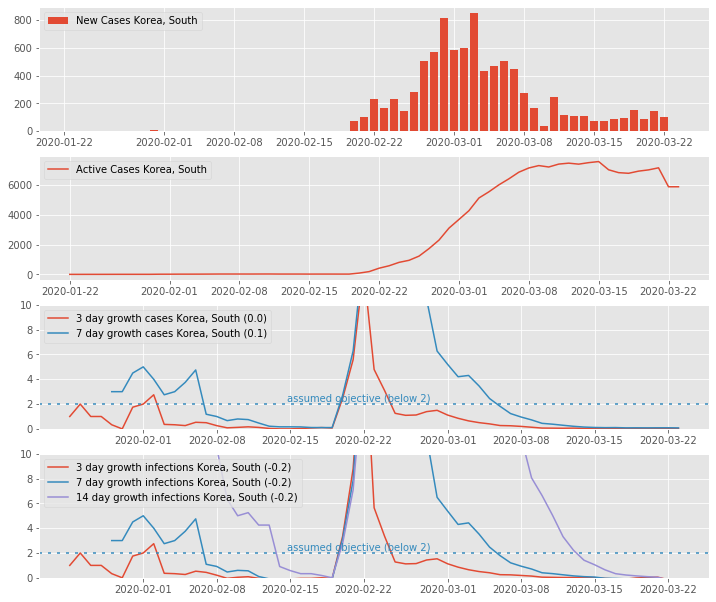

In [68]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(12,10.5))
ax[0].bar(dfCountry.loc[relevant].date,dfCountry.loc[relevant].new_cases,
          label="New Cases {}".format(wCountry.value))
ax[0].legend(loc='upper left')

ax[1].plot(dfCountry.loc[relevant].date,dfCountry.loc[relevant].active,
          label="Active Cases {}".format(wCountry.value))
ax[1].legend(loc='upper left')

ax[2].plot(dfCountry.loc[relevant].date,dfCountry.loc[relevant].growth_rate_3,
           label="3 day growth cases {} ({:.1f})".format(wCountry.value,dfCountry.loc[relevant].growth_rate_3[-1]))
p = ax[2].plot(dfCountry.loc[relevant].date,dfCountry.loc[relevant].growth_rate_7,
           label="7 day growth cases {} ({:.1f})".format(wCountry.value,dfCountry.loc[relevant].growth_rate_7[-1]))
ax[2].legend(loc='upper left')
ax[2].axhline(2.0,color=p[0].get_color(),dashes=[2, 4])
ax[2].set_ylim(0,10)
ax[2].text(dfCountry.loc[relevant[0]].date+(dfCountry.loc[relevant[-1]].date-dfCountry.loc[relevant[0]].date)/2,2,
          "assumed objective (below 2)",color=p[0].get_color(),
          horizontalalignment='center',verticalalignment='bottom')

ax[3].plot(dfCountry.loc[relevant].date,dfCountry.loc[relevant].infection_rate_3,
           label="3 day growth infections {} ({:.1f})".format(wCountry.value,dfCountry.loc[relevant].infection_rate_3[-1]))
p = ax[3].plot(dfCountry.loc[relevant].date,dfCountry.loc[relevant].infection_rate_7,
           label="7 day growth infections {} ({:.1f})".format(wCountry.value,dfCountry.loc[relevant].infection_rate_7[-1]))
ax[3].axhline(2.0,color=p[0].get_color(),dashes=[2, 4])
ax[3].plot(dfCountry.loc[relevant].date,dfCountry.loc[relevant].infection_rate_14,
           label="14 day growth infections {} ({:.1f})".format(wCountry.value,dfCountry.loc[relevant].infection_rate_14[-1]))
ax[3].set_ylim(0,10)
ax[3].text(dfCountry.loc[relevant[0]].date+(dfCountry.loc[relevant[-1]].date-dfCountry.loc[relevant[0]].date)/2,2,
          "assumed objective (below 2)",color=p[0].get_color(),
          horizontalalignment='center',verticalalignment='bottom')
ax[3].legend(loc='upper left')

plt.show()

## Preprocessed Images

### Germany

![Germany](Germany.png "Germany")

### United Kingdom

![United Kingdom](United_Kingdom.png "United Kingdom")

### US

![US](US.png "US")

### Singapore

![Singapore](Singapore.png "Singapore")

### India

![India](India.png "India")

### Italy

![Italy](Italy.png "Italy")

### Spain

![Spain](Spain.png "Italy")

### South Korea

![South Korea](SouthKorea.png "South Korea")